In [43]:
import numpy as np
import matplotlib_inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


In [44]:
batch_size = 32
epochs = 60
learning_rate = .0001

In [45]:
data = np.loadtxt(open("../../datasets/mnist_train_small.csv", "rb"), delimiter=",")

data_only_7 = data[data[:, 0] == 7]
data_without_7 = data[data[:, 0] != 7]

train_data = MinMaxScaler().fit_transform(data_without_7[:, 1:])
train_labels = data_without_7[:, 0]
test_data = MinMaxScaler().fit_transform(data_only_7[:, 1:])
test_labels = data_only_7[:, 0]

train_dataset = TensorDataset(torch.tensor(train_data).float(), torch.tensor(train_labels).long())
test_dataset = TensorDataset(torch.tensor(test_data).float(), torch.tensor(test_labels).long())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=test_dataset.tensors[0].shape[0])

In [46]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(784, 64)

        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 32)

        self.output = nn.Linear(32, 10)

    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [47]:
def create_model():
    model = MnistModel()
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

    return model, loss_func, optimizer

In [48]:
def train_model(model, loss_fn, optimizer):
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    train_acc = torch.zeros(epochs).to(device)
    test_acc = torch.zeros(epochs).to(device)
    losses = torch.zeros(epochs).to(device)

    for epoch_no in range(epochs):
        model.train()

        batch_acc = torch.zeros(len(train_loader)).to(device)
        batch_losses = torch.zeros(len(train_loader)).to(device)

        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)

            output = model(data)
            loss = loss_fn(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_losses[batch_idx] = loss.item()
            matches = torch.argmax(output, dim=1) == target
            matches_float = matches.float()
            accuracy = 100 * torch.mean(matches_float)
            batch_acc[batch_idx] = accuracy

        train_acc[epoch_no] = torch.mean(batch_acc)
        losses[epoch_no] = torch.mean(batch_losses)

        model.eval()
        data, target = next(iter(test_loader))
        data = data.to(device)
        target = target.to(device)
        with torch.no_grad():
            output = model(data)

        matches = torch.argmax(output, dim=1) == target
        matches_float = matches.float()
        accuracy = 100 * torch.mean(matches_float)
        test_acc[epoch_no] = accuracy

    return train_acc, test_acc, losses

In [49]:
def run_the_experiment():
    model, loss_func, optimizer = create_model()

    train_acc, test_acc, _ = train_model(model, loss_func, optimizer)

    return train_acc, test_acc, model

In [50]:
train_acc, test_acc, model = run_the_experiment()

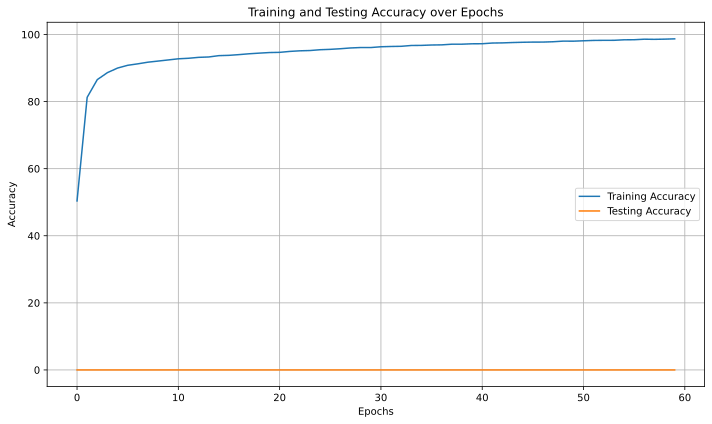

In [51]:
train_acc = train_acc.cpu().numpy()
test_acc = test_acc.cpu().numpy()

plt.figure(figsize=(10, 6))
plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Testing Accuracy")
plt.title("Training and Testing Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [52]:
# run the model through for the test data
X = next(iter(test_loader))[0].to(device)  # note: only need one output, hence the [0]
predictions = model(X).detach()

# save the model guesses
guesses = torch.argmax(predictions, dim=1).detach()

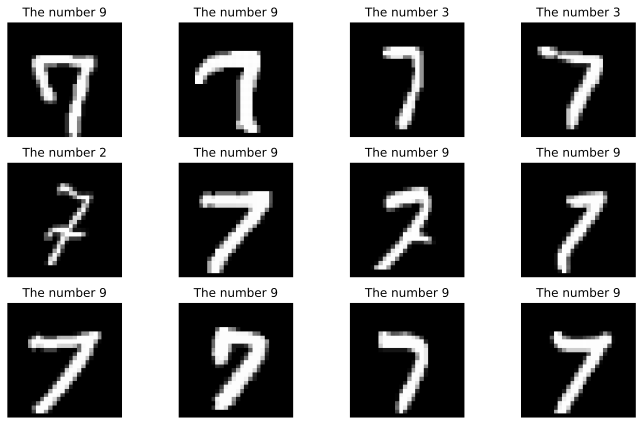

In [53]:
X = X.cpu()
guesses = guesses.cpu()

fig, axs = plt.subplots(3, 4, figsize=(10, 6))

someRandom7s = np.random.choice(len(X), 12)

for i, ax in enumerate(axs.flatten()):
    thisimg = X[someRandom7s[i]].view(28, 28)
    ax.imshow(thisimg, cmap='gray')
    ax.set_title(f'The number {guesses[someRandom7s[i]]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

[0 1 2 3 4 5 6 8 9]


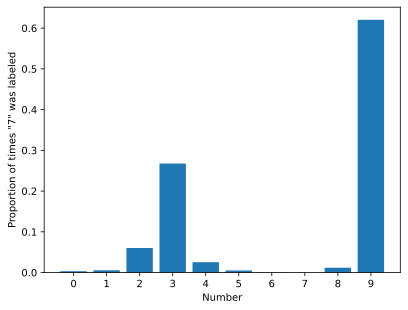

In [54]:
print(np.unique(guesses))

probMistaken = torch.zeros(10)
for i in range(10):
    mask = (guesses == i)
    probMistaken[i] = torch.mean(mask.clone().detach().float())

plt.bar(range(10), probMistaken.numpy())
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Proportion of times \"7\" was labeled")
plt.show()

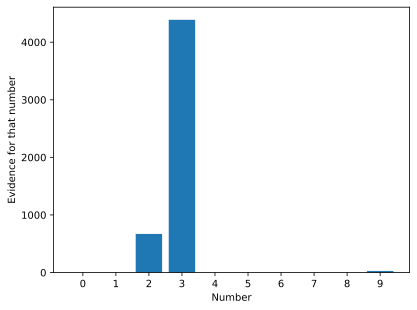

In [55]:
predictions = predictions.cpu()

sample2show = 30

plt.bar(range(10), torch.exp(predictions[sample2show]))
plt.xticks(range(10))
plt.xlabel("Number")
plt.ylabel("Evidence for that number")
plt.show()